<a href="https://colab.research.google.com/github/preritt/CS231n-/blob/master/Cifar10ClassAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import cifar10

Using TensorFlow backend.


In [0]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.metrics import confusion_matrix

170500096/170498071 [==============================] - 19s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


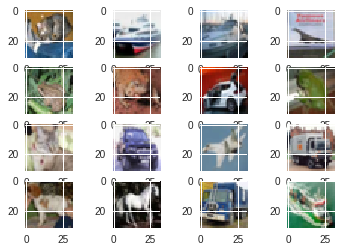

In [3]:
from matplotlib import pyplot
from scipy.misc import toimage
from keras.datasets import cifar10
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:16])


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=90,
                 width_shift_range=0.1, height_shift_range=0.1,
                 horizontal_flip=True)
datagen.fit(x_train)

In [0]:
# generate images using flow
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=90,
                 width_shift_range=0.1, height_shift_range=0.1,
                 horizontal_flip=True)
datagen.fit(x_train)

In [0]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(x_train,
                                                             y_train,
                                                             test_size=0.2,
                                                             random_state=13)

In [46]:
y_train.shape

(50000, 10)

In [0]:
y_test_ground = y_test

In [0]:
# train_ground = to_categorical(train_ground)
# valid_ground = to_categorical(valid_ground)
# y_test_ground = to_categorical(y_test)

In [34]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
ep = 10 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
 
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()
 
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
#training
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(train_X, train_ground, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=ep,\
                    verbose=1,validation_data=(valid_X,valid_ground),callbacks=[LearningRateScheduler(lr_schedule)])
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5') 
 
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
__________

In [35]:
model.history.history

{'acc': [0.4253961267605634,
  0.5909090909090909,
  0.6535091229193342,
  0.6898407490396927,
  0.7200504161331626,
  0.7322343149807938,
  0.7469390204865557,
  0.7608834827144686,
  0.7705865877080665,
  0.7776088348271447],
 'loss': [1.9023341457913994,
  1.293692758767156,
  1.0950409921885453,
  0.9899658419563889,
  0.9111330136752159,
  0.874347757819978,
  0.8423592844326884,
  0.8087905877759911,
  0.7838797084271679,
  0.7640381100922632],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
 'val_acc': [0.5501,
  0.6297,
  0.7081,
  0.7115,
  0.7477,
  0.7471,
  0.7732,
  0.7975,
  0.7834,
  0.7817],
 'val_loss': [1.5098114976882935,
  1.2916825669288636,
  0.971472981262207,
  0.9627156707763672,
  0.8384797581672668,
  0.8363616612911224,
  0.7751194616317749,
  0.7125618876457215,
  0.7791899686813355,
  0.7832756629943848]}

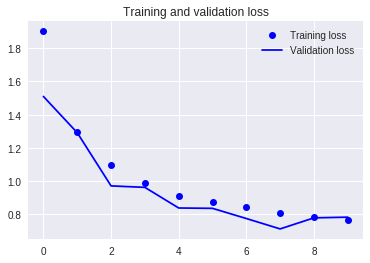

In [36]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

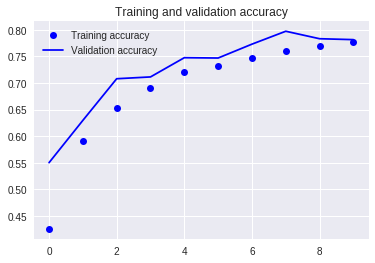

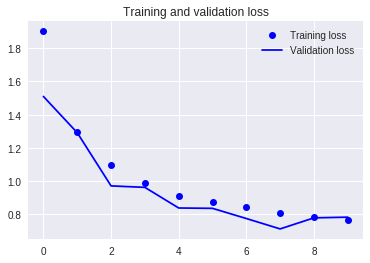

In [37]:
accuracy = model.history.history['acc']
val_accuracy = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [38]:
y_test_ground.shape

(10000, 10, 2)

In [0]:
test_eval = model.evaluate(x_test, y_test, verbose=0)

In [40]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.8012291809082032
Test accuracy: 0.7728


In [0]:
predicted_classes = model.predict(x_test)

In [0]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [0]:
orig_classes = np.argmax(np.round(y_test),axis=1)

In [0]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

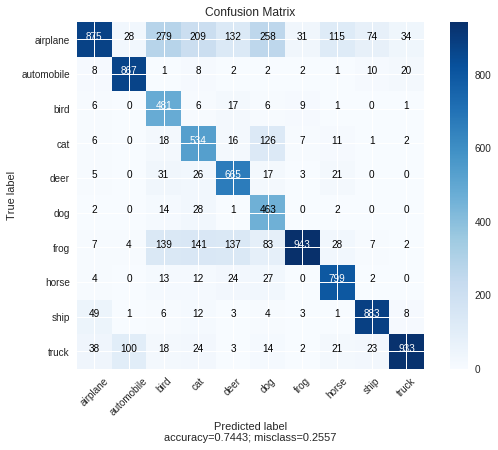

In [52]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
plot_confusion_matrix(cm           = confusion_matrix(predicted_classes, orig_classes), 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")

In [49]:
confusion_matrix(predicted_classes, orig_classes)

array([[875,  28, 279, 209, 132, 258,  31, 115,  74,  34],
       [  8, 867,   1,   8,   2,   2,   2,   1,  10,  20],
       [  6,   0, 481,   6,  17,   6,   9,   1,   0,   1],
       [  6,   0,  18, 534,  16, 126,   7,  11,   1,   2],
       [  5,   0,  31,  26, 665,  17,   3,  21,   0,   0],
       [  2,   0,  14,  28,   1, 463,   0,   2,   0,   0],
       [  7,   4, 139, 141, 137,  83, 943,  28,   7,   2],
       [  4,   0,  13,  12,  24,  27,   0, 799,   2,   0],
       [ 49,   1,   6,  12,   3,   4,   3,   1, 883,   8],
       [ 38, 100,  18,  24,   3,  14,   2,  21,  23, 933]])

## Old setup

In [0]:
# Define function to load the data and conver to array format (#images,dim1,dim2)

In [0]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [0]:
# Extract images

In [0]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [0]:
# Extract labels

In [0]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [0]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [0]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [0]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [0]:
# Explore some images

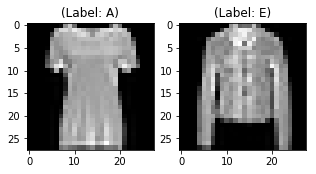

In [0]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [0]:
# convert all images to range 0 to 1 from 0 to 255


In [0]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [0]:
# make sure data is in float32 format

In [0]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [0]:
# rescale data
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [0]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [0]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [0]:
# split the data into test and validation. Here the input and outpur are the same as we are using autoencoder
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [0]:
# model parameters
batch_size = 16
epochs = 1
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [0]:
# define encoder and decoder
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [0]:
# compile the model
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [0]:
# train the model
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Train on 48000 samples, validate on 12000 samples
Epoch 1/1
10128/48000 [=====>........................] - ETA: 38:16 - loss: 0.0241

In [0]:
# save autoencoder weights
autoencoder.save_weights('autoencoder.h5')


In [0]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

In [0]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)


In [0]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape


In [0]:
# define classification model - encoder remains the same
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [0]:
# fully connected layer on top of encoded values
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [0]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [0]:
# 